# Cas de prédiction du Loto français 

In [1]:
#Import des librairies utiles
#https://ledatascientist.com/le-deep-learning-et-le-hasard-prediction-du-loto/
from bs4 import BeautifulSoup
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from tensorflow.keras.callbacks import EarlyStopping

## Fonction de scraping des tirages

In [2]:
#fonction de scraping des tirages du loto
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

In [3]:
#sracping des tirages actuellement disponibles sur le site 
df_tirage=scrap_loto_numbers()

#Calculer de la date
df_tirage['jours'] = df_tirage['month_year'].apply(lambda x : x.split(' ')[0])
df_tirage['month'] =  df_tirage['month_year'].apply(lambda x : x.split(' ')[1])
df_tirage['date']=df_tirage['jours']+'-'+df_tirage['month']

#Vizualisation
df_tirage[['day','month_year','jours','month','date','num0','num1','num2','num3','num4','chance']].head()

,day,month_year,jours,month,date,num0,num1,num2,num3,num4,chance
0,Lundi,05 avril 2021,05,avril,05-avril,2,12,15,22,32,8
1,Samedi,03 avril 2021,03,avril,03-avril,1,2,17,38,45,2
2,Mercredi,31 mars 2021,31,mars,31-mars,2,22,24,27,35,5
3,Lundi,29 mars 2021,29,mars,29-mars,13,18,28,38,41,1
4,Samedi,27 mars 2021,27,mars,27-mars,8,10,11,16,18,5


In [4]:
#Verification de la quatité des données et des info disponible
print(df_tirage.shape)
print(df_tirage.columns)

(1996, 11)
Index(['day', 'month_year', 'num0', 'num1', 'num2', 'num3', 'num4', 'chance',
       'jours', 'month', 'date'],
      dtype='object')


In [5]:
#suppression des tirages du super loto( A explorer later )
df_tirage = df_tirage[(df_tirage['day']!='Vendredi') & (df_tirage['day']!='Mardi')]
print(df_tirage.shape)

(1959, 11)


In [6]:
# Retirer le dernier pour verifier sur ce modèle
#print(df_tirage.head(1)) # le dernier tirrage
#df_tirage.drop(df_tirage.head(1).index, inplace=True)
print(df_tirage.shape)

(1959, 11)


## Traitement  des données

In [7]:
df = df_tirage.iloc[::-1] #inversion du dataframe pour placer le dernier tirage en dernière position
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']] # sélection des variables à traiter
print(df.shape)
df.tail() # le premier tirage devient le dernier

(1959, 6)


,num0,num1,num2,num3,num4,chance
4,8,10,11,16,18,5
3,13,18,28,38,41,1
2,2,22,24,27,35,5
1,1,2,17,38,45,2
0,2,12,15,22,32,8


In [8]:
#fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, 
#sauf celui de chance pour chaque tirage
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

#fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

#fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return (data['chance'].isin(pairs)).astype(int)

#fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return (data['chance'].isin(impairs)).astype(int)

#liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

#Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)

#Nombre de sorties total de ce numéro
def num_sortie(data, column):
    return(data.groupby(column)[column].transform('count')/50)

#Nombre de sorties de ce numéro depuis dernier sortie
def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs

In [9]:
#application des fonctions sur le dataframe
#df['day'] = pd.factorize(df.day)[0]
#df['date'] = pd.factorize(df.date)[0]

df['freq_num0'] = freq_val(df, 'num0')
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance') #Nombre de sorties de ce numéro depuis dernier sortie

df['sum_diff'] = sum_diff(df) #somme de la différence au carré entre chaque couple de numéros successifs dans le tirage
df['pair_chance'] = is_pair_etoile(df)
df['impair_chance'] = is_impair_etoile(df)
df['pair'] = is_pair(df)
df['impair'] = is_impair(df) #verification de nombre pair et impair

df['is_under_24'] = is_under(df, 24)  # Les numeros en dessous de 24 
df['is_under_40'] = is_under(df, 40) # Les numeros en dessous de 40 

#df['sortie_num0'] = num_sortie(df, 'num0')
#df['sortie_num1'] = num_sortie(df, 'num1')
#df['sortie_num2'] = num_sortie(df, 'num2')
#df['sortie_num3'] = num_sortie(df, 'num3')
#df['sortie_num4'] = num_sortie(df, 'num4')
#df['sortie_chance'] = num_sortie(df, 'chance') # nombre de sortie total de chque  chiffre

df.head(6)

,num0,num1,num2,num3,num4,chance,freq_num0,freq_num1,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,is_under_24,is_under_40
1995,19,24,27,33,41,9,1,1,1,1,1,1,134,0,1,1,4,2,4
1994,22,24,32,41,48,1,1,2,1,1,1,1,198,0,1,4,1,2,3
1993,10,20,22,39,46,4,1,1,1,1,1,1,442,1,0,4,1,3,4
1992,10,11,37,41,48,4,2,1,1,2,2,2,742,1,0,2,3,2,3
1991,18,20,28,40,49,1,1,2,1,1,1,2,293,0,1,4,1,2,4
1990,4,32,35,39,44,10,1,1,1,2,1,1,834,1,0,3,2,1,4


## Modèle et fonction de formatage des données en entrée du LSTM

In [10]:
# j'ai ici défini plusieurs modèles à tester mais pour l'intant je tavaille avec le lstm(fonction : define_model)
#Params du modèle
nb_label_feature=6

UNITS = 100
BATCHSIZE = 30
EPOCH = 500 #1500
#ACTIVATION = "softmax"
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae' #'categorical_crossentropy' #mse
DROPOUT = 0.1
window_length = 12 #le nbre de tirage sur lequelle il faut applique
number_of_features = df.shape[1]

#Architecture du modèle
def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.1, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model



#model = define_model(number_of_features,nb_label_feature)
#model3 = define_autoencoder_model(number_of_features,nb_label_feature)
#model4 = define_bidirectionnel_model(number_of_features,nb_label_feature)

#Moniteur pour stoper le training
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=100)

In [11]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm (model 1)  
    #model = define_model(number_of_features,nb_label_feature)
    model = define_autoencoder_model(number_of_features,nb_label_feature)
        
    return train, label, model,scaler

## Training

In [12]:
#formatage des données
train, label, model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)

(1947, 12, 19)
(1947, 6)


* On voit ici que notre dataset d'entrainement après formatage est constitué de 1911 vecteurs contenant chacun 12 tirages où chaque tirage contient 19 features calculés plus haut

* Quant aux labels, on a bien 1911 vecteurs de 6 features soit les 6 numéros de chaque tirages

* Ainsi à partir des 12 tirages précédent on éssaie de prédire le tirage suivant lors de l'entrainement

In [13]:
#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2, callbacks=[es])

Epoch 1/500
65/65 - 1s - loss: 0.8099 - acc: 0.1418
Epoch 2/500
65/65 - 1s - loss: 0.8084 - acc: 0.1474
Epoch 3/500
65/65 - 1s - loss: 0.8074 - acc: 0.1484
Epoch 4/500
65/65 - 1s - loss: 0.8070 - acc: 0.1500
Epoch 5/500
65/65 - 1s - loss: 0.8062 - acc: 0.1479
Epoch 6/500
65/65 - 1s - loss: 0.8052 - acc: 0.1505
Epoch 7/500
65/65 - 1s - loss: 0.8057 - acc: 0.1659
Epoch 8/500
65/65 - 1s - loss: 0.8033 - acc: 0.1582
Epoch 9/500
65/65 - 1s - loss: 0.8022 - acc: 0.1561
Epoch 10/500
65/65 - 1s - loss: 0.7978 - acc: 0.1680
Epoch 11/500
65/65 - 1s - loss: 0.7939 - acc: 0.1664
Epoch 12/500
65/65 - 1s - loss: 0.7878 - acc: 0.1859
Epoch 13/500
65/65 - 1s - loss: 0.7781 - acc: 0.1895
Epoch 14/500
65/65 - 1s - loss: 0.7713 - acc: 0.2024
Epoch 15/500
65/65 - 1s - loss: 0.7610 - acc: 0.1916
Epoch 16/500
65/65 - 1s - loss: 0.7486 - acc: 0.2311
Epoch 17/500
65/65 - 1s - loss: 0.7303 - acc: 0.2435
Epoch 18/500
65/65 - 1s - loss: 0.7145 - acc: 0.2388
Epoch 19/500
65/65 - 1s - loss: 0.6973 - acc: 0.2773
Ep

Epoch 155/500
65/65 - 1s - loss: 0.0955 - acc: 0.8998
Epoch 156/500
65/65 - 1s - loss: 0.0975 - acc: 0.9009
Epoch 157/500
65/65 - 1s - loss: 0.0972 - acc: 0.9070
Epoch 158/500
65/65 - 1s - loss: 0.0968 - acc: 0.8952
Epoch 159/500
65/65 - 1s - loss: 0.0968 - acc: 0.9029
Epoch 160/500
65/65 - 1s - loss: 0.0941 - acc: 0.8983
Epoch 161/500
65/65 - 1s - loss: 0.0962 - acc: 0.8942
Epoch 162/500
65/65 - 1s - loss: 0.0939 - acc: 0.9060
Epoch 163/500
65/65 - 1s - loss: 0.0934 - acc: 0.9060
Epoch 164/500
65/65 - 1s - loss: 0.0957 - acc: 0.8988
Epoch 165/500
65/65 - 1s - loss: 0.0928 - acc: 0.9045
Epoch 166/500
65/65 - 1s - loss: 0.0922 - acc: 0.9070
Epoch 167/500
65/65 - 1s - loss: 0.0905 - acc: 0.9070
Epoch 168/500
65/65 - 1s - loss: 0.0913 - acc: 0.9034
Epoch 169/500
65/65 - 1s - loss: 0.0902 - acc: 0.9106
Epoch 170/500
65/65 - 1s - loss: 0.0933 - acc: 0.8993
Epoch 171/500
65/65 - 1s - loss: 0.0900 - acc: 0.9055
Epoch 172/500
65/65 - 1s - loss: 0.0897 - acc: 0.9081
Epoch 173/500
65/65 - 1s - l

Epoch 307/500
65/65 - 1s - loss: 0.0620 - acc: 0.9430
Epoch 308/500
65/65 - 1s - loss: 0.0600 - acc: 0.9332
Epoch 309/500
65/65 - 1s - loss: 0.0579 - acc: 0.9399
Epoch 310/500
65/65 - 1s - loss: 0.0575 - acc: 0.9389
Epoch 311/500
65/65 - 1s - loss: 0.0582 - acc: 0.9445
Epoch 312/500
65/65 - 1s - loss: 0.0590 - acc: 0.9384
Epoch 313/500
65/65 - 1s - loss: 0.0585 - acc: 0.9435
Epoch 314/500
65/65 - 1s - loss: 0.0579 - acc: 0.9430
Epoch 315/500
65/65 - 1s - loss: 0.0571 - acc: 0.9450
Epoch 316/500
65/65 - 1s - loss: 0.0577 - acc: 0.9414
Epoch 317/500
65/65 - 1s - loss: 0.0620 - acc: 0.9368
Epoch 318/500
65/65 - 1s - loss: 0.0582 - acc: 0.9414
Epoch 319/500
65/65 - 1s - loss: 0.0561 - acc: 0.9440
Epoch 320/500
65/65 - 1s - loss: 0.0569 - acc: 0.9430
Epoch 321/500
65/65 - 1s - loss: 0.0588 - acc: 0.9471
Epoch 322/500
65/65 - 1s - loss: 0.0591 - acc: 0.9420
Epoch 323/500
65/65 - 1s - loss: 0.0571 - acc: 0.9373
Epoch 324/500
65/65 - 1s - loss: 0.0557 - acc: 0.9435
Epoch 325/500
65/65 - 1s - l

Epoch 459/500
65/65 - 1s - loss: 0.0483 - acc: 0.9471
Epoch 460/500
65/65 - 1s - loss: 0.0462 - acc: 0.9456
Epoch 461/500
65/65 - 1s - loss: 0.0446 - acc: 0.9661
Epoch 462/500
65/65 - 1s - loss: 0.0454 - acc: 0.9543
Epoch 463/500
65/65 - 1s - loss: 0.0437 - acc: 0.9579
Epoch 464/500
65/65 - 1s - loss: 0.0438 - acc: 0.9543
Epoch 465/500
65/65 - 1s - loss: 0.0461 - acc: 0.9517
Epoch 466/500
65/65 - 1s - loss: 0.0415 - acc: 0.9620
Epoch 467/500
65/65 - 1s - loss: 0.0424 - acc: 0.9620
Epoch 468/500
65/65 - 1s - loss: 0.0471 - acc: 0.9563
Epoch 469/500
65/65 - 1s - loss: 0.0464 - acc: 0.9527
Epoch 470/500
65/65 - 1s - loss: 0.0478 - acc: 0.9492
Epoch 471/500
65/65 - 1s - loss: 0.0480 - acc: 0.9461
Epoch 472/500
65/65 - 1s - loss: 0.0551 - acc: 0.9440
Epoch 473/500
65/65 - 1s - loss: 0.0486 - acc: 0.9517
Epoch 474/500
65/65 - 1s - loss: 0.0461 - acc: 0.9579
Epoch 475/500
65/65 - 1s - loss: 0.0451 - acc: 0.9450
Epoch 476/500
65/65 - 1s - loss: 0.0450 - acc: 0.9574
Epoch 477/500
65/65 - 1s - l

## Fonction de perte 

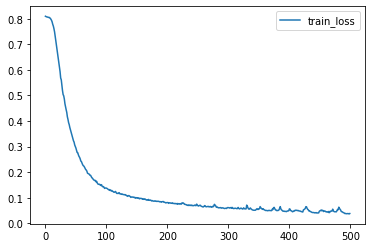

In [14]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

## Prédiction du tirage suivant le dernier tirage de notre dataset de train

In [15]:
#Prediction basée sur les window_length derniers tirages
last_twelve = df.tail(window_length) # on recupere les window_length derniers tirages
last_twelve=last_twelve[::-1] # re-inversion dans l'ordre normale
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

In [16]:
#prediction
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])

[ 1  1 11 32 40  3]
